In [1]:
# Various mesh utilities
# UC Berkeley Math 228B, Per-Olof Persson <persson@berkeley.edu>

using PyPlot
import Delaunator as D

"""
    plot_mapped_grid(R, n1, n2=n1)

Create a Cartesian grid of dimensions (n1+1)-by-(n2+1) on the unit square.
Map it by the functions xy = R(ξη). Plot the resulting structured grid.

Example:

    identity_map(ξη) = ξη
    plot_mapped_grid(identity_map, 40);
"""
function plot_mapped_grid(R, n1, n2=n1)
    xy = Vector{Float64}[ R([ξ,η]) for ξ in (0:n1)./n1, η in (0:n2)./n2 ]
    x,y = first.(xy), last.(xy)
    plot(x, y, "k", x', y', "k", linewidth=1)
end

"""
    t = delaunay(p)

Delaunay triangulation `t` of N x 2 node array `p`.
"""
delaunay(p) = collect(reinterpret(reshape, Int32, 
        D.triangulate(D.PointsFromMatrix(p')).triangles)')

"""
    edges, boundary_indices, emap = all_edges(t)

Find all unique edges in the triangulation `t` (ne x 2 array)
Second output is indices to the boundary edges.
Third output emap (nt x 3 array) is a mapping from local triangle edges
to the global edge list, i.e., emap[it,k] is the global edge number
for local edge k (1,2,3) in triangle it.
"""
function all_edges(t)
    etag = vcat(t[:,[1,2]], t[:,[2,3]], t[:,[3,1]])
    etag = hcat(sort(etag, dims=2), 1:3*size(t,1))
    etag = sortslices(etag, dims=1)
    dup = all(etag[2:end,1:2] - etag[1:end-1,1:2] .== 0, dims=2)[:]
    keep = .![false;dup]
    edges = etag[keep,1:2]
    emap = cumsum(keep)
    invpermute!(emap, etag[:,3])
    emap = reshape(emap,:,3)
    dup = [dup;false]
    dup = dup[keep]
    bndix = findall(.!dup)
    return edges, bndix, emap
end

"""
    e = boundary_nodes(t)

Find all boundary nodes in the triangulation `t`.
"""
function boundary_nodes(t)
    edges, boundary_indices, _ = all_edges(t)
    return unique(edges[boundary_indices,:][:])
end

"""
    tplot(p, t, u=nothing)

If `u` == nothing: Plot triangular mesh with nodes `p` and triangles `t`.
If `u` == solution vector: Plot filled contour color plot of solution `u`.
"""
function tplot(p, t, u=nothing)
    clf()
    axis("equal")
    if u == nothing
        tripcolor(p[:,1], p[:,2], Array(t .- 1), 0*t[:,1],
                  cmap="Set3", edgecolors="k", linewidth=1)
    else
        tricontourf(p[:,1], p[:,2], Array(t .- 1), u[:], 20)
    end
    draw()
end

"""
    inside = inpolygon(p, pv)

Determine if each point in the N x 2 node array `p` is inside the polygon
described by the NE x 2 node array `pv`.
"""
function inpolygon(p, pv)
    if ndims(p) == 2 && size(p,2) == 2
        return [ inpolygon(p[ip,:], pv) for ip = 1:size(p,1) ]
    end
    cn = 0
    for i = 1:size(pv,1) - 1
        if pv[i,2] <= p[2] && pv[i+1,2] > p[2] ||
           pv[i,2] > p[2] && pv[i+1,2] <= p[2]
            vt = (p[2] - pv[i,2]) / (pv[i+1,2] - pv[i,2])
            if p[1] < pv[i,1] + vt * (pv[i+1,1] - pv[i,1])
                cn += 1
            end
        end
    end
    return cn % 2 == 1
end

inpolygon

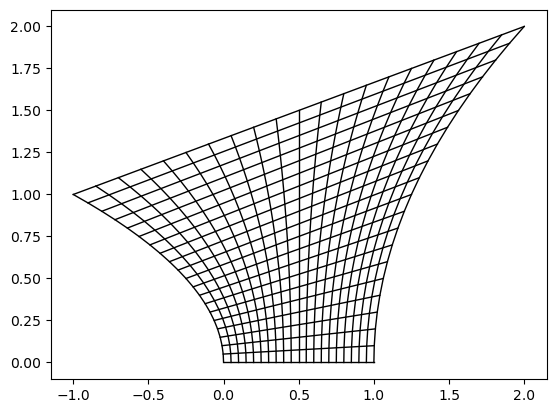

In [2]:
### Example: Plot a mapped structured grid

Rmap(ξη) = [ξη[1] - (ξη[2]^2 - 2ξη[1]*ξη[2]^2), ξη[2]*(1 + ξη[1])]
plot_mapped_grid(Rmap, 20);

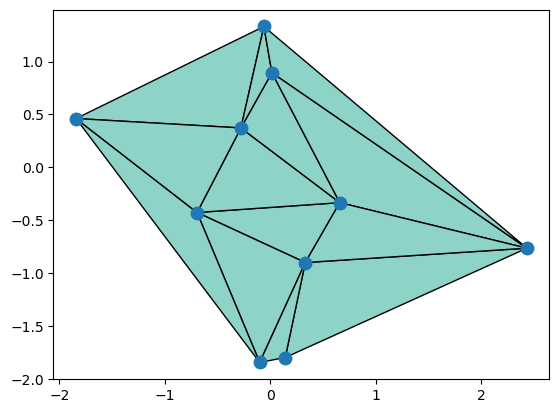

(PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x7f8ae6f2c8b0>], (-2.0566694380473134, 2.6478366574693486, -2.0027220863540998, 1.4902851564636492))

In [3]:
### Example: Create and plot Delaunay triangulation of random points

p = randn(10,2)
t = delaunay(p)
tplot(p,t)
plot(p[:,1], p[:,2], ".", markersize=18), axis("equal")


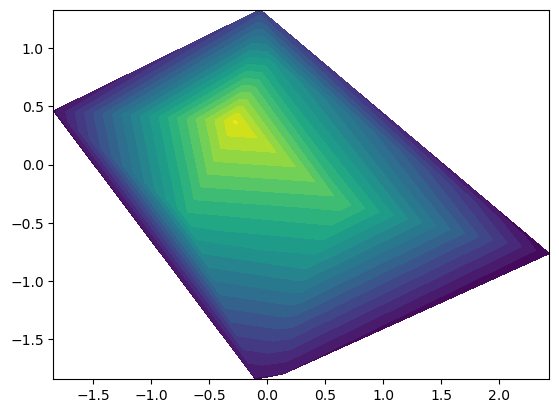

In [4]:
### Example: Plot function on mesh as color contours
u = @. exp(-(p[:,1]^2 + p[:,2]^2))
tplot(p, t, u)

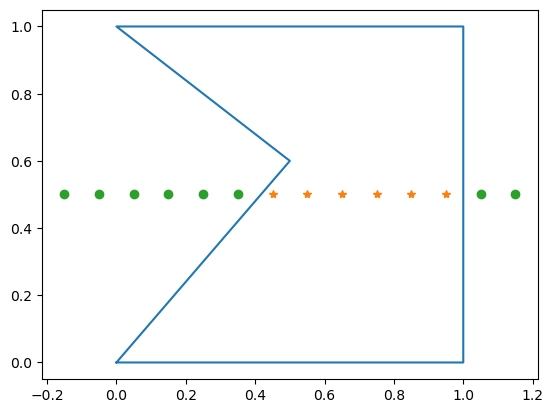

In [5]:
### Example: Demonstrate the inpolygon() function

pv = [0 0; 1 0; 1 1; 0 1; 0.5 0.6; 0 0]
x = collect(-.15:0.1:1.15)
p = [x 0*x.+0.5]
inside = inpolygon(p, pv)
plot(pv[:,1], pv[:,2],
     p[inside,1], p[inside,2], "*",
     p[.!inside,1], p[.!inside,2], "o");